# Part 4: Quantization

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2025-05-22 10:50:57.333184: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 10:50:57.358117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 10:50:57.358138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 10:50:57.358143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 10:50:57.363271: I tensorflow/core/platform/cpu_feature_g

## Fetch the jet tagging dataset from Open ML

In [2]:
#X_train_val = np.load('X_train_val.npy')
#X_test = np.load('X_test.npy')
#y_train_val = np.load('y_train_val.npy')
#y_test = np.load('y_test.npy')
#classes = np.load('classes.npy', allow_pickle=True)

n_samples = 1000
X_train_val = np.random.rand(n_samples, 32, 32, 3).astype("float64")
y_train_val = X_train_val[:,:,:,0].copy().astype("float32")  # auto-encoder target is the input itself
X_test = np.random.rand(n_samples, 32, 32, 3).astype("float64")
y_test = X_test[:,:,:,0].copy().astype("float32")  # auto-encoder target is the input itself

print(X_train_val.shape, y_train_val.shape)
print(X_train_val.dtype, y_train_val.dtype)
print(X_train_val[0:5])
print(y_train_val[0:5])

(1000, 32, 32, 3) (1000, 32, 32)
float64 float32
[[[[0.5488135  0.71518937 0.60276338]
   [0.54488318 0.4236548  0.64589411]
   [0.43758721 0.891773   0.96366276]
   ...
   [0.09394051 0.5759465  0.9292962 ]
   [0.31856895 0.66741038 0.13179786]
   [0.7163272  0.28940609 0.18319136]]

  [[0.58651293 0.02010755 0.82894003]
   [0.00469548 0.67781654 0.27000797]
   [0.73519402 0.96218855 0.24875314]
   ...
   [0.23789282 0.934214   0.61396596]
   [0.5356328  0.58990998 0.73012203]
   [0.311945   0.39822106 0.20984375]]

  [[0.18619301 0.94437239 0.7395508 ]
   [0.49045881 0.22741463 0.25435648]
   [0.05802916 0.43441663 0.31179588]
   ...
   [0.87428797 0.29302028 0.84894356]
   [0.61787669 0.01323686 0.34723352]
   [0.14814086 0.98182939 0.47837031]]

  ...

  [[0.63250897 0.51462554 0.13772485]
   [0.6490696  0.856035   0.09321247]
   [0.75368009 0.69021128 0.86666057]
   ...
   [0.82530262 0.24393779 0.33160215]
   [0.34306693 0.80104203 0.03703027]
   [0.07378698 0.57845155 0.39711199

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
import tensorflow.keras.models as models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, UpSampling2D
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv2D, QConv2DBatchnorm
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
def single_conv_down(inputs, out_channels):
    x = Conv2D(out_channels, 3, activation="relu", padding="same")(inputs)
    x = MaxPooling2D(2, padding="same")(x)
    return x

def single_conv_up(inputs, out_channels):
    x = Conv2D(out_channels, 3, activation="relu", padding="same")(inputs)
    x = UpSampling2D(2)(x)
    return x

def double_conv_down(inputs, out_channels):
    x = Conv2D(out_channels, 3, activation="relu", padding="same")(inputs)
    x = Conv2D(out_channels, 3, activation="relu", padding="same")(x)
    x = MaxPooling2D(2, padding="same")(x)
    return x

def double_conv_up(inputs, out_channels):
    x = Conv2D(out_channels, 3, activation="relu", padding="same")(inputs)
    x = Conv2D(out_channels, 3, activation="relu", padding="same")(x)
    x = UpSampling2D(2)(x)
    return x


def single_qconv_down(inputs, out_channels, nbits, nbitsi):    
    x = QConv2D(
        out_channels,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        bias_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        padding="same"
    )(inputs)
    x = QActivation(f'quantized_relu({nbits})')(x) 
    x = MaxPooling2D(2, padding="same")(x)
    return x

def single_qconv_up(inputs, out_channels, nbits, nbitsi):
    x = QConv2D(
        out_channels,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        bias_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        padding="same"
    )(inputs)
    x = QActivation(f'quantized_relu({nbits})')(x) 
    x = UpSampling2D(2)(x)
    return x

def double_qconv_down(inputs, out_channels, nbits, nbitsi):
    x = QConv2D(
        out_channels,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        bias_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        padding="same"
    )(inputs)
    x = QActivation(f'quantized_relu({nbits})')(x) 
    x = QConv2D(
        out_channels,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        bias_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        padding="same"
    )(x)
    x = QActivation(f'quantized_relu({nbits})')(x) 
    x = MaxPooling2D(2, padding="same")(x)
    return x

def double_qconv_up(inputs, out_channels, nbits, nbitsi):
    x = QConv2D(
        out_channels,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        bias_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        padding="same"
    )(inputs)
    x = QActivation(f'quantized_relu({nbits})')(x) 
    x = QConv2D(
        out_channels,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        bias_quantizer=f"quantized_bits({nbits},{nbitsi},alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        padding="same"
    )(x)
    x = QActivation(f'quantized_relu({nbits})')(x) 
    x = UpSampling2D(2)(x)
    return x

def build_depth_autoencoder(input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape, name="input_image")

    # ------- Encoder -------
    x = single_conv_down(inputs, 4)
    x = single_conv_down(x, 8)
    encoded = single_conv_down(x, 16)
    
    # ------- Decoder -------
    x = single_conv_up(encoded, 16)
    x = single_conv_up(x, 8)
    x = single_conv_up(x, 4)
    
    outputs = Conv2D(1, 3, activation="sigmoid", padding="same",
                            name="reconstructed_depth")(x)

    return models.Model(inputs, outputs, name="depth_autoencoder")

def build_depth_q_autoencoder(input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape, name="input_depth")

    # ------- Encoder -------
    x = single_qconv_down(inputs, 16, 16, 6)
    x = single_qconv_down(x, 16, 16, 6)
    encoded = single_qconv_down(x, 16, 16, 6)
    
    # ------- Decoder -------
    x = single_qconv_up(encoded, 16, 16, 6)
    x = single_qconv_up(x, 16, 16, 6)
    x = single_qconv_up(x, 16, 16, 6)

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same",
                            name="reconstructed_depth")(x)

    return models.Model(inputs, outputs, name="depth_autoencoder")

model = build_depth_q_autoencoder()
model.summary()

2025-05-22 10:50:59.007073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-22 10:50:59.007094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: administrateur-ThinkStation-P2-Tower
2025-05-22 10:50:59.007097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: administrateur-ThinkStation-P2-Tower
2025-05-22 10:50:59.007197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.230.2
2025-05-22 10:50:59.007208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.230.2
2025-05-22 10:50:59.007211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.230.2


Model: "depth_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_depth (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 32, 32, 16)        448       
                                                                 
 q_activation (QActivation)  (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 q_conv2d_1 (QConv2D)        (None, 16, 16, 16)        2320      
                                                                 
 q_activation_1 (QActivatio  (None, 16, 16, 16)        0         
 n)                                              

## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
#from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
#from tensorflow_model_optimization.sparsity.keras import strip_pruning

#pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
#model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    #adam = Adam(lr=0.0001)
    #model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    #model.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])
    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss="mse",
        metrics=["mae"],
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='estimate_sign_example',
    )
    #callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        # batch_size=8,
        epochs=100,
        validation_split=0.25,
        # shuffle=True,
        # callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    # model = strip_pruning(model)
    model.save('estimate_depth_example/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('estimate_depth_example/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/100
24/24 [==============================] - 1s 20ms/step - loss: 0.1707 - mae: 0.2503 - val_loss: 0.1662 - val_mae: 0.2495
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.1630 - mae: 0.2502 - val_loss: 0.1586 - val_mae: 0.2494
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1555 - mae: 0.2502 - val_loss: 0.1513 - val_mae: 0.2494
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1483 - mae: 0.2502 - val_loss: 0.1443 - val_mae: 0.2494
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1414 - mae: 0.2502 - val_loss: 0.1376 - val_mae: 0.2494
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1350 - mae: 0.2502 - val_loss: 0.1314 - val_mae: 0.2494
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1289 - mae: 0.2502 - val_loss: 0.1255 - val_mae: 0.2494
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 0.1232 - 

24/24 [==============================] - 0s 8ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 62/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 63/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 64/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 65/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 66/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 67/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0831 - val_mae: 0.2494
Epoch 68/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0834 - m

/home/emanuel/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/emanuel/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [7]:
y_sw = model.predict(X_test)

print(X_test[0:10])
print(y_test[0:10])
print(y_sw[0:10])

32/32 [==============================] - 0s 3ms/step
[[[[0.27766925 0.63711741 0.61342521]
   [0.99520215 0.50858625 0.38003636]
   [0.72989374 0.07407213 0.95444723]
   ...
   [0.75968259 0.50186416 0.20229695]
   [0.59230512 0.29196204 0.28379006]
   [0.49718693 0.70232327 0.07979386]]

  [[0.38464328 0.79825183 0.32953335]
   [0.3797024  0.11509733 0.91462799]
   [0.95870451 0.01627014 0.04771824]
   ...
   [0.25154031 0.69878072 0.5440213 ]
   [0.05013554 0.10908644 0.59881197]
   [0.15823285 0.25733126 0.36667446]]

  [[0.64588206 0.29695379 0.92930922]
   [0.56902466 0.07809727 0.55676401]
   [0.77471154 0.25113872 0.23373092]
   ...
   [0.52651836 0.7724174  0.00662166]
   [0.7509683  0.7137595  0.79703285]
   [0.99964164 0.23257003 0.95242072]]

  ...

  [[0.8681664  0.90446879 0.84072868]
   [0.18557462 0.84294394 0.59769258]
   [0.0170843  0.58686024 0.36091516]
   ...
   [0.11808917 0.58840288 0.50200637]
   [0.84748407 0.7517753  0.67078254]
   [0.9721196  0.06334263 0.3619

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [8]:
#import hls4ml
#import plotting

#config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(
#    model, hls_config=config, backend='Vitis', output_dir='estimate_sign_example/hls4ml_prj', part='xc7z020clg400-1'
#)
#hls_model.compile()

#y_qkeras = model.predict(np.ascontiguousarray(X_test))
#y_hls = hls_model.predict(np.ascontiguousarray(X_test))
#np.save('estimate_sign_example/y_qkeras.npy', y_qkeras)
#np.save('estimate_sign_example/y_hls.npy', y_hls)

In [9]:
#%matplotlib inline
#from sklearn.metrics import accuracy_score
#from tensorflow.keras.models import load_model

#model_ref = load_model('estimate_sign_example/KERAS_check_best_model.h5')
#y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
#print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
#print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

#fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None)  # reset the colors
#_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
#plt.gca().set_prop_cycle(None)  # reset the colors
#_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

#from matplotlib.lines import Line2D

#lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
#from matplotlib.legend import Legend

#leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
#ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vitis_hls.log`

In [10]:
# hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [11]:
# hls4ml.report.read_vivado_report('estimate_sign_example/hls4ml_prj')

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [12]:
# hls4ml.report.read_vivado_report('estimate_sign_example/hls4ml_prj')

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vitis HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [13]:
# hls4ml.report.read_vivado_report('estimate_sign_example/hls4ml_prj')

## NB
Note as well that the Vitis HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.

In [14]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
#config['Model']['Precision']['default'] = 'ap_fixed<6,2>'
#config['Model']['ReuseFactor'] = 1
config['Model']['Strategy'] = 'Resource'

#config = hls4ml.utils.config_from_keras_model(model, granularity='name')
#config['Model']['Precision']['default'] = 'ap_fixed<8,4>'
#config['LayerName']['fc1_input']['Precision']['result'] = 'float'
#config['LayerName']['output_linear']['Precision']['result'] = 'float'

#config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#for layer in ['fc1', 'fc2', 'fc3', 'output']:
#    config['LayerName'][layer]['ReuseFactor'] = 64
#for layer in ['fc1']:
#    config['LayerName'][layer]['ReuseFactor'] = 64
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config,
    output_dir='estimate_depth_example/hls4ml_prj_pynq',
    backend='VivadoAccelerator',
    board='pynq-z2',
    io_type='io_stream'
)
hls_model.compile()

/home/emanuel/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_depth, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 32, 32, 16]], output shape: [None, 32, 32, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 32, 32, 16]], output shape: [None, 16, 16, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 16, 16, 16]], output shape: [None, 16, 16, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 16, 16, 16]], output shape: [None, 16, 16, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 16, 16, 16]], output shape: [None, 8, 8, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 8, 8, 16]], output shape: [None, 8, 8, 16]
Layer name: q_activation_2, layer ty

In [15]:
plotting.print_dict(hls4ml.backends.get_backend('VivadoAccelerator').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
ClockUncertainty:    12.5%
IOType:              io_parallel
HLSConfig
WriterConfig
  Namespace:         None
  WriteWeightsTxt:   True
  WriteTar:          False
AcceleratorConfig
  Board:             pynq-z2
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float


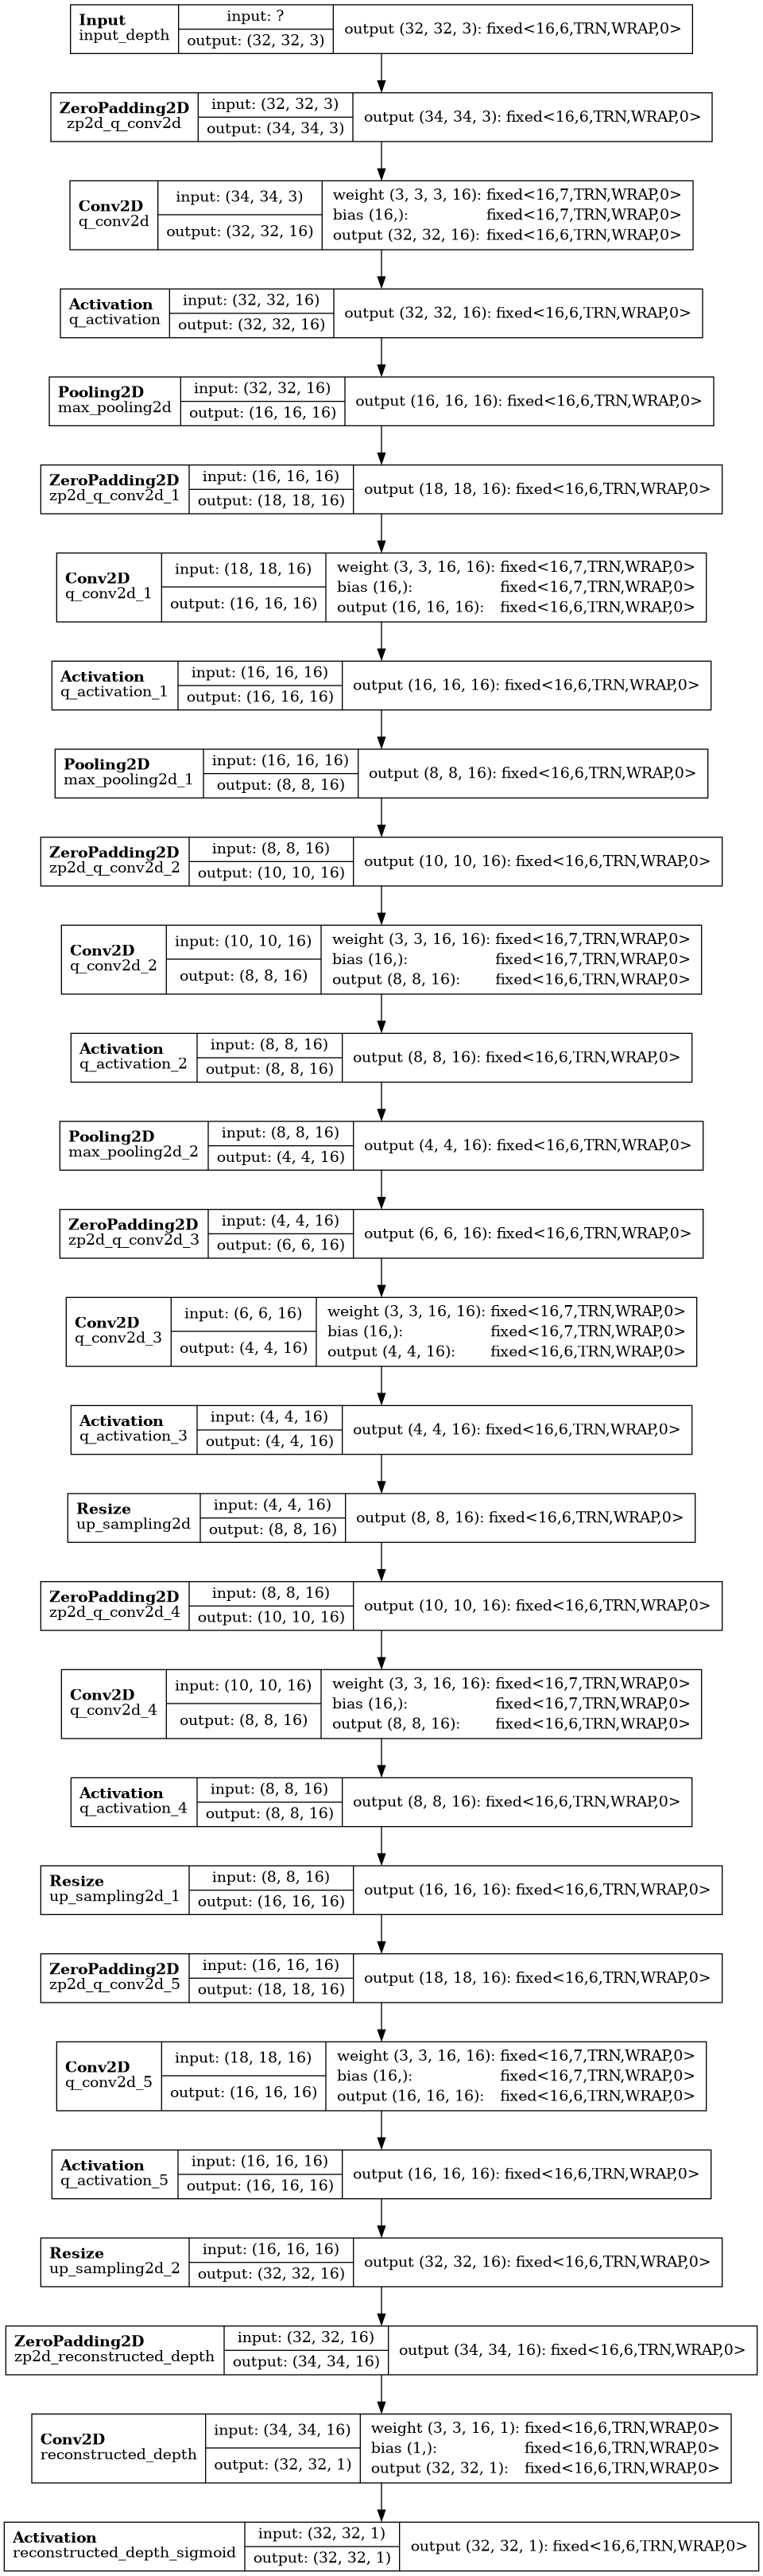

In [16]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [17]:
#import numpy as np

#X_test = np.load('X_test.npy')
#y_hls = hls_model.predict(np.ascontiguousarray(X_test))
#np.save('estimate_sign_example/y_hls.npy', y_hls)

In [18]:
hls_model.build(csim=False, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'emanuel' on host 'administrateur-ThinkStation-P2-Tower' (Linux_x86_64 version 6.11.0-25-generic) on Thu May 22 10:51:26 CEST 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_prj_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_prj_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 20

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'myproject_axi' (firmware/myproject_axi.cpp:21).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'nnet::fill_data<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config28>' (firmware/nnet_utils/nnet_padding_stream.h:24).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'nnet::fill_data<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config28>' (firmware/nnet_utils/nnet_padding_stream.h:24).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>::operator[].1' into 'nnet::fill_zero<nnet::array<ap_fixed<1

INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_buffer_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config26>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config26>' (firmware/nnet_utils/nnet_conv2d_stream.h:108).
INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:25 ; elapsed = 00:00:25 . Memory (MB): peak = 1647.734 ; gain = 1193.191 ; free physical = 14329 ; free virtual = 28499
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_de

INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config28>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config28>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.2.1' (firmware/nnet_utils/nnet_padding_stream.h:22) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config28>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'n

INFO: [HLS 200-489] Unrolling loop 'ResizeWidth' (firmware/nnet_utils/nnet_image_stream.h:44) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config25>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'ResizeChan' (firmware/nnet_utils/nnet_image_stream.h:51) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config25>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ImageWidth' (firmware/nnet_utils/nnet_image_stream.h:22) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config21>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ImageChan' (firmware/nnet_utils/nnet_image_stream.h:28) in function 'nnet::resize_nearest<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config21>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResizeHeight' (firmwar

INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:192) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config13>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config13>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:205) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config13>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (firmware/nnet_utils/nnet_

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:80) in function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:228) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:236) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:239) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a fact

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:80) in function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:228) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:236) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:239) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor o

INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.16' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V' (firmware/nnet_utils/nnet_image_stream.h:19) in dimension 1 automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.0' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.1' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.2' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.3' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.4' (firmware/nnet_utils/nnet_image_stream.h:19) automatically.
INFO: [XFORM 203-102] Partitioning array 'data_in_row.data.V.5' (firmware/nnet_utils/nnet_image_stream.h:19) automatica

INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:36) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b2.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:36) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.8' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.13' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.18' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.23' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.28' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.33' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 

INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_resource.h:82) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>' (firmware/nnet_utils/nnet_dense_resource.h:82) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config22_mult>.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config22_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[11].V' to 'b22.V.11'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config22_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config22_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[12].V' to 'b22.V.12'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_reso

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[15].V' to 'b18.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14_mult>'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14_mult>.0' by setting 'weights.V' to 'w14.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0' by setting 'biases[0].V' to 'b10.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>.0.0.0' by setting 'biases[1].V' to 'b10.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0' by setting 'biases[7].V' to 'b6.V.7'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:42:9) to 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6_mult>.0.0.0.0.0.0.0.0.0.0' by setting 'biases[8].V' to 'b6.V.8'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode

INFO: [XFORM 203-721] Changing loop 'Loop_1_proc' (firmware/myproject_axi.cpp:17) to a process function for dataflow in function 'myproject_axi'.
INFO: [XFORM 203-721] Changing loop 'Loop_2_proc' (firmware/myproject_axi.cpp:29) to a process function for dataflow in function 'myproject_axi'.
INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 27 process function(s): 
	 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config28>'
	 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config4>'
	 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6

INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:26:25 ; elapsed = 00:26:26 . Memory (MB): peak = 1647.734 ; gain = 1193.191 ; free physical = 14179 ; free virtual = 28356
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:241:66) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:241:66) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:241:66) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:26:48 ; elapsed = 00:26:49 . Memory (MB): peak = 1804.574 ; gain = 1350.031 ; free physical = 13888 ; free virtual = 28065
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_axi' ...


INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc672' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1609.63 seconds; current allocated memory: 776.457 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.12 seconds; current allocated memory: 776.995 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_3u_config28_s' 
INFO: [HLS 200-10] ----------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed<16, 6, 5, 3, 0>, 16u>, config6>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.13 seconds; current allocated memory: 783.662 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.07 seconds; current allocated memory: 783.963 MB.
INFO: [HLS 

INFO: [HLS 200-111]  Elapsed time: 0.1 seconds; current allocated memory: 791.629 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.07 seconds; current allocated memory: 792.128 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config12_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.12 seconds; current 

   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25) and fifo read on port 'image_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:25).
   between fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:57) and fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:57).
   between fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:57) and fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_stream.h:57).
   between fifo write on port 'resized_V_data_0_V' (firmware/nnet_utils/nnet_image_strea

INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.71 seconds; current allocated memory: 805.536 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.25 seconds; current allocated memory: 806.999 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config33_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.28 seconds; current allocated memory: 807.290 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: 

INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 64, Depth = 65.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.52 seconds; current allocated memory: 812.117 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.47 seconds; current allocated memory: 814.609 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config34_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.43 seconds; current allocated memory:

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_3u_config28_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_ap_fixed_3u_array_ap_fixed_16_6_5_3_0_3u_config28_s'.
INFO: [HLS 200-111]  Elapsed time: 0.21 seconds; current allocated memory: 850.241 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s_line_buffer_Array_V_6_0_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s_line_buffer_Array_V_bkb' due to t

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config29_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config29_s'.
INFO: [HLS 200-111]  Elapsed time: 0.57 seconds; current allocated memory: 868.216 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_V_4_0_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_VxdS' due to the length limit 80
I

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 0.18 seconds; current allocated memory: 875.525 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config8_s'.
INFO: [HLS 200-111]  Elapsed time: 0.18 seconds; current allocated memory: 877.780 

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_s'.
INFO: [HLS 200-111]  Elapsed time: 0.6 seconds; current allocated memory: 890.407 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_0_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bjl' due to the length limit 80
IN

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 0.2 seconds; current allocated memory: 894.770 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 0.22 seconds; current allocated memory: 897.681 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config12_s' 
INFO: [HLS 200-10] --------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_16_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config13_s'.
INFO: [HLS 200-111]  Elapsed time: 0.67 seconds; current allocated memory: 904.766 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config31_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config31_s'.
INFO: [HLS 200-111]  Elapsed time: 0.64 seconds; current allocated memory: 912.590 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s' 
INFO: [HLS 200-10] --------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config14_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_16u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 0.24 seconds; current allocated memory: 916.985 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config14_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 0.26 seconds; current allocated memory: 

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_V_2_1_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_c0C' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_V_2_0_13' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_c1C' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_V_2_1_13' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_c2C' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_V_2_0_14' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config18_s_line_buffer_Array_c3C' due to the length limit 80
INFO: [SYN 201-210] Renamed object n

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_V_3_0_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_dvH' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_V_3_1_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_dwH' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_V_3_0_13' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_dxH' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_V_3_1_13' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config22_s_line_buffer_Array_dyH' due to the length limit 80
INFO: [SYN 201-210] Renamed object n

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_V_5_1_11' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_d0M' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_V_5_0_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_d1M' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_V_5_1_12' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_d2M' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_V_5_0_13' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config26_s_line_buffer_Array_d3M' due to the length limit 80
INFO: [SYN 201-210] Renamed object n

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_1u_config26_s'.
INFO: [HLS 200-111]  Elapsed time: 2.91 seconds; current allocated memory: 1.051 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config26_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config26_s'.
INFO: [HLS 200-111]  Elapsed time: 0.8 seconds; current allocated memory: 1.058 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_fixed_16_6_5_3_0_1u_sigmoid_config27_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: 

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_6_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_7_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_8_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_9_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_10_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_11_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_12_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_13_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_14_V_U(fifo_w16_d1024_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_15_V_U(fifo_w16_d1024_A)' us

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_10_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_11_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_12_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_13_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_14_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_15_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_0_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_1_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_2_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_3_V_U(fifo_w16_d64_A)' u

INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_V_data_14_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer13_out_V_data_15_V_U(fifo_w16_d16_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_0_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_1_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_2_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_3_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_4_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_5_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V_data_6_V_U(fifo_w16_d36_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer31_out_V

INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_3_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_4_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_5_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_6_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_7_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_8_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_9_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_10_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V_data_11_V_U(fifo_w16_d64_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer18_out_V

INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_7_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_8_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_9_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_10_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_11_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_12_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_13_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_14_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_15_V_U(fifo_w16_d256_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_0_V_U(fifo_w16_d1024_A)' u

INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config24ehP_U(start_for_relu_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_16u_relu_config24ehP)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_resize_nearest_array_ap_fixed_16_6_5_3_0_16u_config25_U0_U(start_for_resize_nearest_array_ap_fixed_16_6_5_3_0_16u_config25_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config34_U0_U(start_for_zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config34_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config26eiP_U(start_for_conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config26eiP)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_sigmoid_array_array_ap_fixed_16_6_5_3_0_1u_sigmoid_config27_U0_U(start_for_sigmoid

INFO: [Ipptcl 7-1463] No Compatible Board Interface found. Board Tab not created in customize GUI
Slave segment '/axi_dma_0/S_AXI_LITE/Reg' is being assigned into address space '/processing_system7_0/Data' at <0x4040_0000 [ 64K ]>.
# apply_bd_automation -rule xilinx.com:bd_rule:axi4 -config { Clk_master {Auto} Clk_slave {Auto} Clk_xbar {Auto} Master {/axi_dma_0/M_AXI_MM2S} Slave {/processing_system7_0/S_AXI_HP0} ddr_seg {Auto} intc_ip {New AXI Interconnect} master_apm {0}}  [get_bd_intf_pins processing_system7_0/S_AXI_HP0]
Slave segment '/processing_system7_0/S_AXI_HP0/HP0_DDR_LOWOCM' is being assigned into address space '/axi_dma_0/Data_MM2S' at <0x0000_0000 [ 512M ]>.
# endgroup
# apply_bd_automation -rule xilinx.com:bd_rule:axi4 -config { Clk_master {Auto} Clk_slave {/processing_system7_0/FCLK_CLK0 (100 MHz)} Clk_xbar {/processing_system7_0/FCLK_CLK0 (100 MHz)} Master {/axi_dma_0/M_AXI_S2MM} Slave {/processing_system7_0/S_AXI_HP0} ddr_seg {Auto} intc_ip {/axi_mem_intercon} master_ap

INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s00_couplers/auto_us .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s01_couplers/auto_us .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/m00_couplers/auto_pc .
INFO: [BD 41-1029] Generation completed for the IP Integrator block hier_0/axi_dma_0 .
INFO: [BD 41-1029] Generation completed for the IP Integrator block hier_0/myproject_axi_0 .
Exporting to file /home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh
Generated Block Design Tcl file /home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1_bd.tcl
Generated Hardware Definition File /home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_

INFO: [Project 1-454] Reading design checkpoint '/home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_myproject_axi_0_0/design_1_myproject_axi_0_0.dcp' for cell 'design_1_i/hier_0/myproject_axi_0'
INFO: [Project 1-454] Reading design checkpoint '/home/emanuel/workspace/hls4ml-tutorial/estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_auto_pc_0/design_1_auto_pc_0.dcp' for cell 'design_1_i/ps7_0_axi_periph/s00_couplers/auto_pc'
Netlist sorting complete. Time (s): cpu = 00:00:00.21 ; elapsed = 00:00:00.21 . Memory (MB): peak = 2126.910 ; gain = 0.000 ; free physical = 13135 ; free virtual = 27477
INFO: [Netlist 29-17] Analyzing 2218 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-479] Netlist was created with Vivado 2020.1
INFO: [Project 1-570] Prepa

INFO: [Timing 38-35] Done setting XDC timing constraints.
Ending Cache Timing Information Task | Checksum: e39295f1

Time (s): cpu = 00:00:05 ; elapsed = 00:00:05 . Memory (MB): peak = 2753.410 ; gain = 420.371 ; free physical = 12610 ; free virtual = 26953

Starting Logic Optimization Task

Phase 1 Retarget
INFO: [Opt 31-138] Pushed 2 inverter(s) to 12 load pin(s).
INFO: [Opt 31-49] Retargeted 0 cell(s).
Phase 1 Retarget | Checksum: 198c5b2c3

Time (s): cpu = 00:00:02 ; elapsed = 00:00:00.73 . Memory (MB): peak = 2920.285 ; gain = 0.000 ; free physical = 12439 ; free virtual = 26781
INFO: [Opt 31-389] Phase Retarget created 34 cells and removed 115 cells
INFO: [Opt 31-1021] In phase Retarget, 24 netlist objects are constrained preventing optimization. Please run opt_design with -debug_log to get more detail. 

Phase 2 Constant propagation
INFO: [Opt 31-138] Pushed 2 inverter(s) to 9 load pin(s).
Phase 2 Constant propagation | Checksum: 22688eaa5

Time (s): cpu = 00:00:02 ; elapsed = 0

Phase 1.3 Build Placer Netlist Model | Checksum: f888ca6b

Time (s): cpu = 00:00:09 ; elapsed = 00:00:04 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12301 ; free virtual = 26652

Phase 1.4 Constrain Clocks/Macros
Phase 1.4 Constrain Clocks/Macros | Checksum: f888ca6b

Time (s): cpu = 00:00:09 ; elapsed = 00:00:04 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12301 ; free virtual = 26652
Phase 1 Placer Initialization | Checksum: f888ca6b

Time (s): cpu = 00:00:09 ; elapsed = 00:00:04 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12301 ; free virtual = 26652

Phase 2 Global Placement

Phase 2.1 Floorplanning
Phase 2.1 Floorplanning | Checksum: de77dc30

Time (s): cpu = 00:00:11 ; elapsed = 00:00:05 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12314 ; free virtual = 26665

Phase 2.2 Global Placement Core

Phase 2.2.1 Physical Synthesis In Placer
INFO: [Physopt 32-1035] Found 0 LUTNM shape to break, 1896 LUT instanc

INFO: [Place 30-746] Post Placement Timing Summary WNS=0.510. For the most accurate timing information please run report_timing.
Phase 4.1.1 Post Placement Optimization | Checksum: 1a20c829b

Time (s): cpu = 00:01:14 ; elapsed = 00:00:32 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12353 ; free virtual = 26704
Phase 4.1 Post Commit Optimization | Checksum: 1a20c829b

Time (s): cpu = 00:01:15 ; elapsed = 00:00:33 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12353 ; free virtual = 26704

Phase 4.2 Post Placement Cleanup
Phase 4.2 Post Placement Cleanup | Checksum: 1a20c829b

Time (s): cpu = 00:01:15 ; elapsed = 00:00:33 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12354 ; free virtual = 26705

Phase 4.3 Placer Reporting
Phase 4.3 Placer Reporting | Checksum: 1a20c829b

Time (s): cpu = 00:01:15 ; elapsed = 00:00:33 . Memory (MB): peak = 3430.488 ; gain = 0.000 ; free physical = 12354 ; free virtual = 26705

Phase 4.4 Final Placement

 Number of Nodes with overlaps = 13
 Number of Nodes with overlaps = 22
 Number of Nodes with overlaps = 6
 Number of Nodes with overlaps = 4
 Number of Nodes with overlaps = 0
INFO: [Route 35-416] Intermediate Timing Summary | WNS=0.050  | TNS=0.000  | WHS=N/A    | THS=N/A    |

Phase 4.2 Global Iteration 1 | Checksum: 23651758d

Time (s): cpu = 00:01:43 ; elapsed = 00:00:59 . Memory (MB): peak = 3442.211 ; gain = 11.723 ; free physical = 12123 ; free virtual = 26503
Phase 4 Rip-up And Reroute | Checksum: 23651758d

Time (s): cpu = 00:01:43 ; elapsed = 00:01:00 . Memory (MB): peak = 3442.211 ; gain = 11.723 ; free physical = 12123 ; free virtual = 26503

Phase 5 Delay and Skew Optimization

Phase 5.1 Delay CleanUp

Phase 5.1.1 Update Timing
Phase 5.1.1 Update Timing | Checksum: 17bd6d31f

Time (s): cpu = 00:01:45 ; elapsed = 00:01:00 . Memory (MB): peak = 3442.211 ; gain = 11.723 ; free physical = 12124 ; free virtual = 26504
INFO: [Route 35-416] Intermediate Timing Summary | WNS=0.06

INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Vivado 12-3199] DRC finished with 0 Errors, 1 Warnings
INFO: [Vivado 12-3200] Please refer to the DRC report (report_drc) for more information.
INFO: [Designutils 20-2272] Running write_bitstream with 8 threads.
Loading data files...
Loading site data...
Loading route data...
Processing options...
Creating bitmap...
Creating bitstream...
Writing bitstream ./design_1_wrapper.bit...
INFO: [Vivado 12-1842] Bitgen Completed Successfully.
INFO: [Project 1-120] WebTalk data collection is mandatory when using a WebPACK part without a full Vivado license. To see the specific WebTalk data collected for your design, open the usage_statistics_webtalk.html or usage_statistics_webtalk.xml file in the implementation directory.
INFO: [Common 17-83] Releasing license: Implementation
146 Infos, 5 Warnings, 0 Critical Warnings and 0 Errors encountered.
write_bitstream completed successfully
write_bitstream: Time (s): cpu = 00:00:19 ; elapsed = 00:00:19

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.429',
  'BestLatency': '29697',
  'WorstLatency': '29697',
  'IntervalMin': '29698',
  'IntervalMax': '29698',
  'BRAM_18K': '364',
  'DSP': '103',
  'FF': '51042',
  'LUT': '59341',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.065,
  'TNS': 0.0,
  'WHS': 0.016,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [19]:
!sed -n '30,45p' estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt


+----------------------------+-------+-------+-----------+-------+
|          Site Type         |  Used | Fixed | Available | Util% |
+----------------------------+-------+-------+-----------+-------+
| Slice LUTs                 | 19837 |     0 |     53200 | 37.29 |
|   LUT as Logic             | 19081 |     0 |     53200 | 35.87 |
|   LUT as Memory            |   756 |     0 |     17400 |  4.34 |
|     LUT as Distributed RAM |    22 |     0 |           |       |
|     LUT as Shift Register  |   734 |     0 |           |       |
| Slice Registers            | 22927 |     0 |    106400 | 21.55 |
|   Register as Flip Flop    | 22927 |     0 |    106400 | 21.55 |
|   Register as Latch        |     0 |     0 |    106400 |  0.00 |
| F7 Muxes                   |     2 |     0 |     26600 | <0.01 |
| F8 Muxes                   |     1 |     0 |     13300 | <0.01 |
+----------------------------+-------+-------+-----------+-------+



In [20]:
!mkdir -p estimate_depth_example/hls4ml_prj_pynq/package
!cp estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit estimate_depth_example/hls4ml_prj_pynq/package/hls4ml_nn.bit
!cp estimate_depth_example/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh estimate_depth_example/hls4ml_prj_pynq/package/hls4ml_nn.hwh
!cp estimate_depth_example/hls4ml_prj_pynq/axi_stream_driver.py estimate_depth_example/hls4ml_prj_pynq/package/
np.save('estimate_depth_example/hls4ml_prj_pynq/package/X_test.npy', X_test)
np.save('estimate_depth_example/hls4ml_prj_pynq/package/y_test.npy', y_test)
#!cp X_test.npy y_test.npy estimate_sign_example/hls4ml_prj_pynq/package
!cp part7b_deployment.ipynb estimate_depth_example/hls4ml_prj_pynq/package

!tar -czvf estimate_depth_example/hls4ml_prj_pynq/package.tar.gz -C estimate_depth_example/hls4ml_prj_pynq/package/ .

./
./X_test.npy
./hls4ml_nn.bit
./y_test.npy
./hls4ml_nn.hwh
./part7b_deployment.ipynb
./axi_stream_driver.py
